In [51]:
# Convert lines of frame to Python dictionaries
def sniffer_log_to_dict(sniffer_log: "List[Str]") -> "List[Dict]":
    ret_dicts = []
    last_timestamp = 0
    overflow_counts = 0
    for l in sniffer_log:
        ret_dict = {}
        this_timestamp = int(l[:10])/1e6
        if last_timestamp > this_timestamp:
            # Overflow, add 2**32
            overflow_counts += 1
        last_timestamp = this_timestamp
        this_timestamp += 2**32/1e6*overflow_counts
        ret_dict["timestamp"] = this_timestamp
        ret_dict["channel"] = int(l[13:15])
        ret_dict["rssi"] = int(l[18:21])
        ret_dict["frame_type"] = l[22:24]
        ret_dict["ds_flag"] = l[25:27]
        ret_dict["dest_mac"] = l[28:40]
        ret_dict["src_mac"] = l[41:53]
        ret_dicts += [ret_dict]
    return ret_dicts

In [110]:
sp435 = sniffer_log_to_dict(open("../SNIFFER435.LOG").readlines())
sp436 = sniffer_log_to_dict(open("../SNIFFER436.LOG").readlines())
sp437 = sniffer_log_to_dict(open("../SNIFFER437.LOG").readlines())

NameError: name 'lines' is not defined

In [74]:
sp4 = sp5 = sp6 = []
with open("serport4.log") as f:
    sp4 = f.readlines()
with open("serport5.log") as f:
    sp5 = f.readlines()
with open("serport6.log") as f:
    sp6 = f.readlines()
len(sp4)

4442

In [19]:
sp4[10][14:24]

TypeError: unhashable type: 'slice'

In [4]:
def filter_valid_lines(in_list):
    out_list = []
    for l in in_list:
        if len(l) != 25:
            # Wrong length
            continue
        if l[0] != "R" and l[0] != "N":
            # Wrong header
            continue
        out_item = {}
        try:
            int(l[1:13],16)
            int(l[14:24],10)
        except ValueError:
            # Wrong format
            continue
        out_item["new"] = l[0] == 'N'
        out_item["mac"] = l[1:13]
        out_item["time"] = l[14:24]
        out_list += [out_item]
    return out_list

In [75]:
sp4 = filter_valid_lines(sp4)[0:3200]
sp5 = filter_valid_lines(sp5)[41:3241]
sp6 = filter_valid_lines(sp6)[58:3258]

In [143]:
len(set(s["mac"] for s in sp6) & set(s["mac"] for s in sp5))

336

5

In [100]:
len(set(s["mac"] for s in sp5))

1564

In [165]:
def floaten_time(in_list):
    for l in in_list:
        l["time"] = int(l["time"])/1e6

In [173]:
def unwrap_time(in_list):
    if type(in_list[0]["time"]) == float:
        assert False, "Already unwrapped"
    last_ts = int(in_list[0]["time"])
    cur_ts_add = 0
    for l in in_list:
        now_ts = int(l["time"])
        if now_ts < 2000000000:
            # Wrapped
            cur_ts_add = (1<<32)/1e6
        else:
            cur_ts_add = 0
        l["time"] = now_ts/1e6+cur_ts_add

In [174]:
floaten_time(sp4)
floaten_time(sp5)
unwrap_time(sp6)

In [214]:
def relativize_time(in_list):
    start_ts = in_list[0]["time"]
    for l in in_list:
        l["time"] -= start_ts

In [216]:
relativize_time(sp4)
relativize_time(sp5)
relativize_time(sp6)

In [176]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [149]:
# color key, map mac address bottom 2 digits to colors
int(sp5[0]["mac"][-2:],16)/256

0.0

In [210]:
# Find most common mac address and match based on it?
from collections import Counter
common_macs = set(s["mac"] for s in sp4) & set(s["mac"] for s in sp6) & set(s["mac"] for s in sp6)
mac_cnt = Counter([s["mac"] for s in sp4 if s["mac"] in common_macs]+[s["mac"] for s in sp6 if s["mac"] in common_macs]+[s["mac"] for s in sp5 if s["mac"] in common_macs])

In [211]:
mac_cnt.most_common()

[('0095691eaf22', 283),
 ('a03be3089361', 143),
 ('98e79a51579c', 116),
 ('3096fbdba555', 113),
 ('b83765c52a9f', 98),
 ('041b6da2f70a', 95),
 ('6c72e70c5001', 91),
 ('8866a59236eb', 89),
 ('7c01914ff945', 87),
 ('000fc3000b00', 74),
 ('1a4c101fffff', 64),
 ('38378b220f90', 63),
 ('000000000b00', 62),
 ('c8e0eb40bad5', 55),
 ('cc3a61b906df', 53),
 ('b8634d699535', 52),
 ('c0a53e7403c8', 49),
 ('b0481a70f329', 47),
 ('38a4ed4d7391', 46),
 ('00aefa50a503', 46),
 ('446d57e835b4', 45),
 ('c0174da95ead', 45),
 ('a03be30514ec', 43),
 ('010fc3000b00', 42),
 ('8866a5df5b4a', 42),
 ('145f942956a7', 38),
 ('c0174da96cb5', 35),
 ('1c36bbc45d50', 34),
 ('c0a53e0ff5f3', 34),
 ('149d09096d0e', 32),
 ('884477fab8fa', 32),
 ('4c49e3f99a15', 30),
 ('203cae8b82ac', 29),
 ('dc415fd255f0', 29),
 ('7423448d1118', 28),
 ('dc3714749446', 28),
 ('9801a76ae955', 28),
 ('c83c85ad8899', 27),
 ('1aec1103ffff', 27),
 ('608334f2d21d', 26),
 ('a03be3afa1ce', 26),
 ('2cf0a2d34853', 26),
 ('484b20010d24', 24),
 ('000f

In [223]:
sp4_filtered = [s for s in sp4 if s["mac"] == '98e79a51579c']
sp5_filtered = [s for s in sp5 if s["mac"] == '98e79a51579c']
sp6_filtered = [s for s in sp6 if s["mac"] == '98e79a51579c']

In [218]:
def add_sniff_plot(in_list,x_offset,y_offset):
    plt.scatter([s["time"]+x_offset for s in in_list],[y_offset]*len(in_list),c=[int(s["mac"][-2:],16)/256 for s in in_list])

<IPython.core.display.Javascript object>


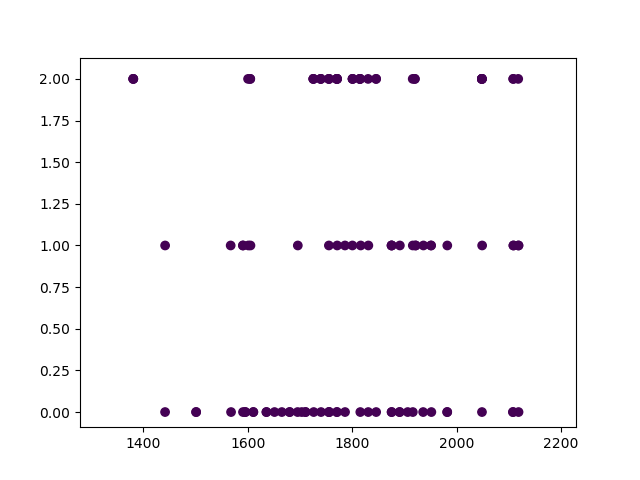

In [226]:
plt.close()
add_sniff_plot(sp4_filtered,0,0)
add_sniff_plot(sp5_filtered,20.52,1)
add_sniff_plot(sp6_filtered,29.1,2)
plt.show()

In [68]:
len(sp6)

0

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

[]

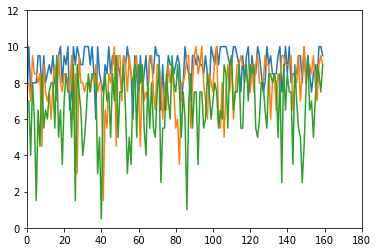

In [35]:
plt.figure()
plt.plot([len([s for s in sp4[i*20:i*20+20] if s["new"]])/2 for i in range(160)])
plt.plot([len([s for s in sp5[i*20:i*20+20] if s["new"]])/2 for i in range(160)])
plt.plot([len([s for s in sp6[i*20:i*20+20] if s["new"]])/2 for i in range(160)])
plt.xlim(0,180)
plt.ylim(0,12)
plt.plot()

In [44]:
common_macs = set(s["mac"] for s in sp4) & set(s["mac"] for s in sp5) & set(s["mac"] for s in sp6)

In [45]:
len(common_macs)

220

In [49]:
sorted([(i, len([s for s in sp4+sp5+sp6 if s["mac"] == i])) for i in common_macs],key=lambda x: x[1])

[('e251e47c4f28', 3),
 ('daa1198a5a7e', 3),
 ('9cb2b22b79e2', 3),
 ('5a4213f7f1f8', 3),
 ('6021011fc4a9', 3),
 ('020fc3000100', 4),
 ('4248e28fb581', 4),
 ('98e79a5692fa', 4),
 ('1abf2fa1fffc', 4),
 ('de420c564069', 4),
 ('3a69f47083d0', 4),
 ('94652dca21b2', 4),
 ('42d293a7448f', 4),
 ('7a2c4cc27dbd', 4),
 ('daa119c0499d', 5),
 ('82125c64fa4e', 5),
 ('daa11968602b', 5),
 ('8256ab065b5c', 5),
 ('d65319eef22f', 5),
 ('aa84c8ed4bc4', 5),
 ('daa119bf80f6', 5),
 ('daa119f6bd86', 5),
 ('daa1190b65ec', 5),
 ('be5d5fcf082c', 5),
 ('1ad5c501cf4b', 5),
 ('aa59fe1924c5', 5),
 ('7264cd8ac165', 5),
 ('daa11995fb90', 5),
 ('daf71ca699d3', 5),
 ('5e9f5858aff8', 5),
 ('daa11979355a', 5),
 ('daeabc6e65d0', 5),
 ('9ce33f587340', 6),
 ('daa119bbb9fc', 6),
 ('68dbca03b564', 6),
 ('4040a74b0cff', 6),
 ('a6870e9535a9', 6),
 ('daa11974e3e3', 6),
 ('daa119b207c4', 6),
 ('fa4c063abdaa', 6),
 ('daa119116c21', 6),
 ('aa89906d0fc2', 6),
 ('460571100000', 6),
 ('daa119895521', 6),
 ('a652b9ac0007', 6),
 ('b67f939

In [77]:
def plot_sniffers(mac):
    sp4_thismac = [s["time"][:4] for s in sp4 if s["mac"] == mac]
    sp5_thismac = [s["time"][:4] for s in sp5 if s["mac"] == mac]
    sp6_thismac = [s["time"][:4] for s in sp6 if s["mac"] == mac]
    plt.figure()
    plt.scatter(sp4_thismac,[4]*len(sp4_thismac))
    plt.scatter(sp5_thismac,[5]*len(sp5_thismac))
    plt.scatter(sp6_thismac,[6]*len(sp6_thismac))
    plt.title(mac+' sniffers')
    plt.plot()

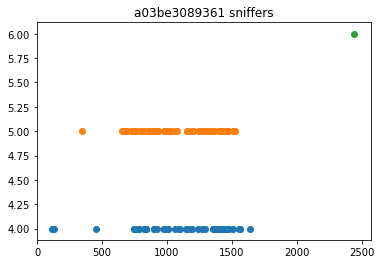

In [79]:
plot_sniffers('a03be3089361')

In [82]:
len([s["time"][:4] for s in sp5 if s["mac"] == 'a03be3089361'])

85

(0, 1800)

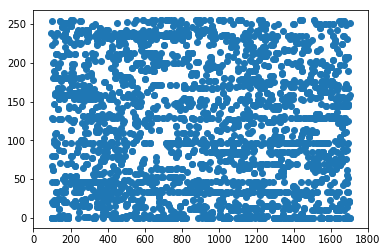

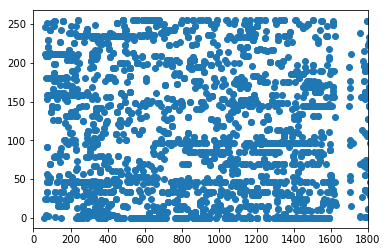

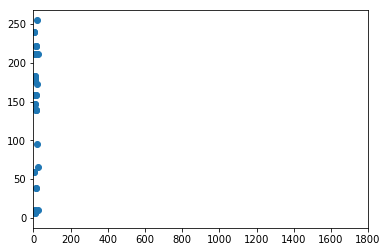

In [86]:
plt.figure()
plt.scatter([s["time"][:4] for s in sp4],[int(s["mac"][-2:],16) for s in sp4])
plt.xlim(0,1800)
plt.figure()
plt.scatter([s["time"][:4] for s in sp5],[int(s["mac"][-2:],16) for s in sp5])
plt.xlim(0,1800)
plt.figure()
plt.scatter([s["time"][:4] for s in sp6],[int(s["mac"][-2:],16) for s in sp6])
plt.xlim(0,1800)